In [1]:
from src.utils.train_utils import *
from src.utils.test_utils import *
from src.utils.feature_analyzer import *
from src.utils.plot_utils import *

### Import the data

In [2]:
train_df_path = '../../data/synth_data_train_labeled.csv'
test_df_path = '../../data/synth_data_test_labeled.csv'
fi_dir = 'feature_importance'
target_model_dir = "../../model"

In [3]:
cols_to_drop = ['checked', 'Ja', 'Nee']
train_df = add_checked(pd.read_csv(train_df_path))
X_train = train_df.astype(np.float32)
y_train = train_df['checked']

In [4]:
test_df = add_checked(pd.read_csv(test_df_path))
X_test = test_df.drop(cols_to_drop, axis=1)
X_test = X_test.astype(np.float32)
y_test = test_df['checked']

### Manipulate the data

In [5]:
# Manipulate the data to reduce/increase bias
def data_manipulator(X, y):
    ########INSERT DATA MANIPULATION CODE HERE##########
    
    problem_features = filter_features(X.columns)
    
    for feature in problem_features:
        X[feature] = X[feature].mean() # Average values of problematic features to effectively 'remove' them from the model
    return X, y
    ####################################################

X_prime, y_prime = data_manipulator(X_train, y_train)

X_prime.head()

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,Ja,Nee,checked
0,4.0,4.0,1.0,1.0,6345.0,1.0,0.00392,0.00314,0.49388,0.00111,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.550907,0.449093,0.0
1,1.0,1.0,1.0,0.0,17546.0,1.0,0.00392,0.00314,0.49388,0.00111,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.411258,0.588742,0.0
2,5.0,2.0,0.0,0.0,4052.0,1.0,0.00392,0.00314,0.49388,0.00111,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.690235,0.309765,0.0
3,2.0,1.0,0.0,0.0,16335.0,1.0,0.00392,0.00314,0.49388,0.00111,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.710640,0.289359,1.0
4,3.0,1.0,0.0,0.0,20872.0,1.0,0.00392,0.00314,0.49388,0.00111,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.394054,0.605946,0.0


### Evaluate feature importances

In [6]:
fa = FeatureAnalyzer()
# fa.evaluate_importance(dataframe=X_prime, target='checked', add_drop=['Ja', 'Nee'], filepath=latest_ver_path) # Uncomment this line if you don't have the feature_importance.pkl file

In [7]:
latest_ver_name = get_versioned_name(fi_dir, 'fi_v', '.pkl', create_new=False) # set to true to create new version
latest_ver_path = fi_dir + '/' + latest_ver_name

if all(col in X_prime.columns for col in cols_to_drop):
    X_prime = X_prime.drop(['checked', 'Ja', 'Nee'], axis=1)
    
print(f'Loading feature importance data from {latest_ver_name}')

print(latest_ver_path)

Loading feature importance data from fi_v2.pkl
feature_importance/fi_v2.pkl


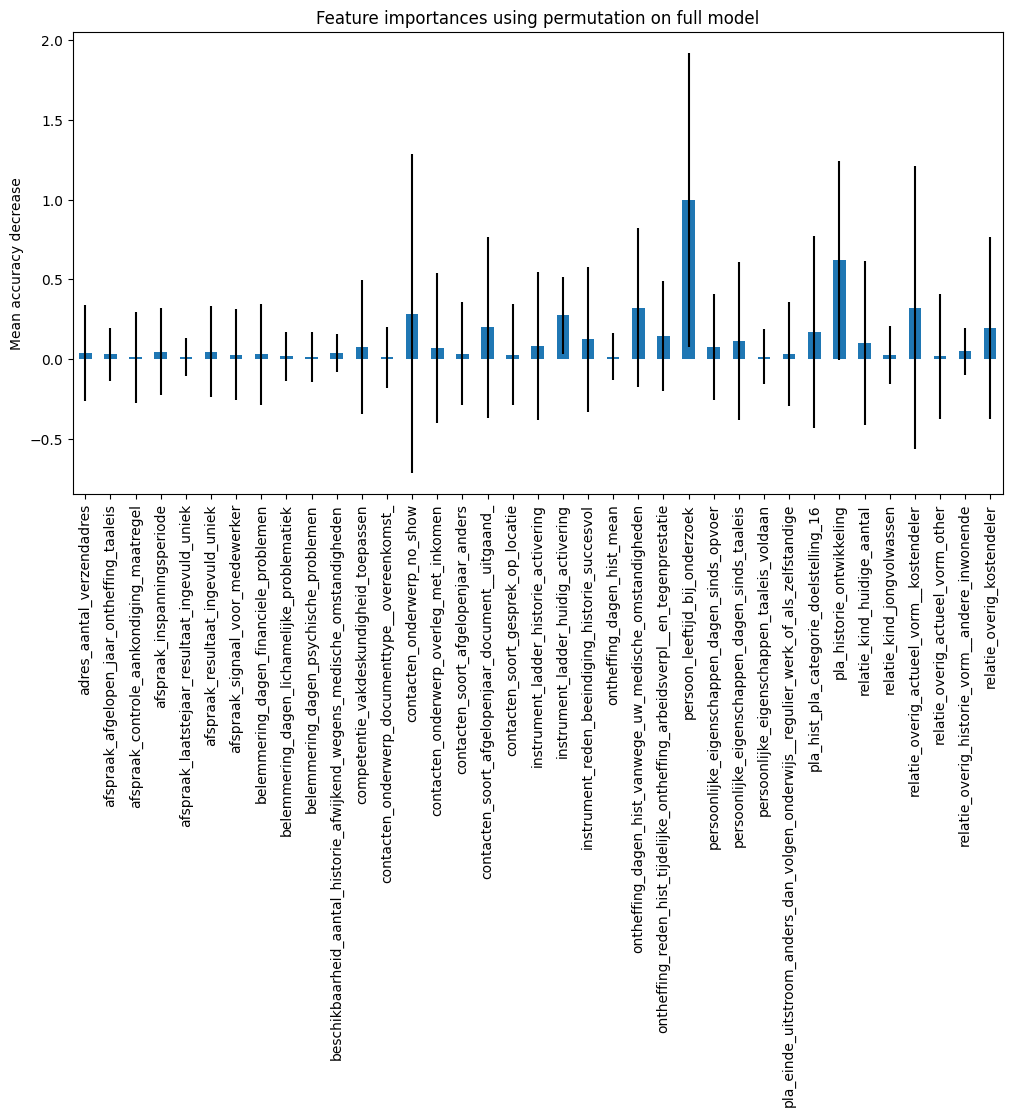

In [8]:
fa.load_importance(filepath='feature_importance/fi_v0.pkl')
fa.plot_importance(column_names=X_prime.columns, min_val=0.01)

In [9]:
fad = fa.feature_importance_as_dict(column_names=X_prime.columns, normalize=True)
sorted_fi = dict(sorted(fad.items(), key=lambda item: item[1], reverse=True)[:10])

print("Top 10 most important features according to permutation importance:")
for rank, feature in enumerate(sorted_fi):
    print(f'{rank+1}: {feature} - {sorted_fi[feature]:.4f}')

Top 10 most important features according to permutation importance:
1: persoon_leeftijd_bij_onderzoek - 1.0000
2: pla_historie_ontwikkeling - 0.6204
3: ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden - 0.3231
4: relatie_overig_actueel_vorm__kostendeler - 0.3230
5: contacten_onderwerp_no_show - 0.2855
6: instrument_ladder_huidig_activering - 0.2757
7: contacten_soort_afgelopenjaar_document__uitgaand_ - 0.2004
8: relatie_overig_kostendeler - 0.1964
9: pla_hist_pla_categorie_doelstelling_16 - 0.1712
10: ontheffing_reden_hist_tijdelijke_ontheffing_arbeidsverpl__en_tegenprestatie - 0.1452


### Visualize modified data distributions

In [10]:
X_en, top_features_en = translate_cols(X_prime, sorted_fi)
top_features_en

{'person_age_at_investigation': 0.28241609566621595,
 'pla_history_development': 0.1751989409214568,
 'exemption_days_hist_due to_your_medical_conditions': 0.09124368989947483,
 'relationship_other_current_form_cost_sharer': 0.09122914211728429,
 'contacts_subject_no_show': 0.08063835668252353,
 'instrument_ladder_current_activation': 0.07785973028411819,
 'contacts_type_last_year_document_outgoing': 0.056605420503644165,
 'relationship_other_cost_sharer': 0.05545614571058626,
 'pla_hist_pla_category_objective_16': 0.04835682800157116,
 'exemption_reason_hist_temporary_dispensation_work_shift_and_compensation': 0.0409956502131249}

C:\Users\chena\PycharmProjects\TestingProject\src\utils\plot_utils.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = data.groupby('Bins')['Counts'].sum()


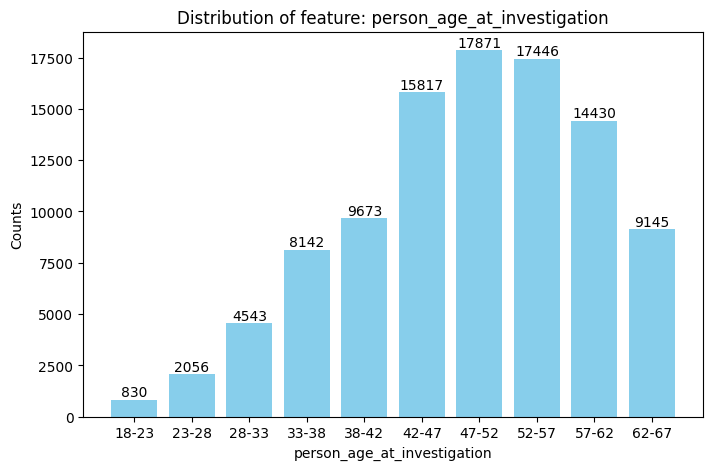

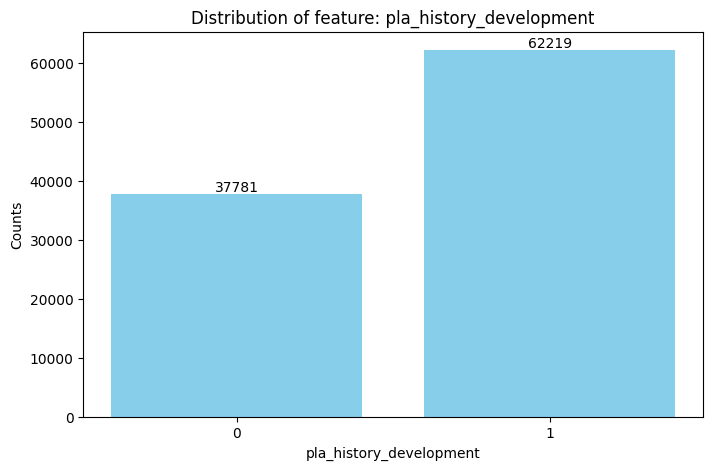

C:\Users\chena\PycharmProjects\TestingProject\src\utils\plot_utils.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = data.groupby('Bins')['Counts'].sum()


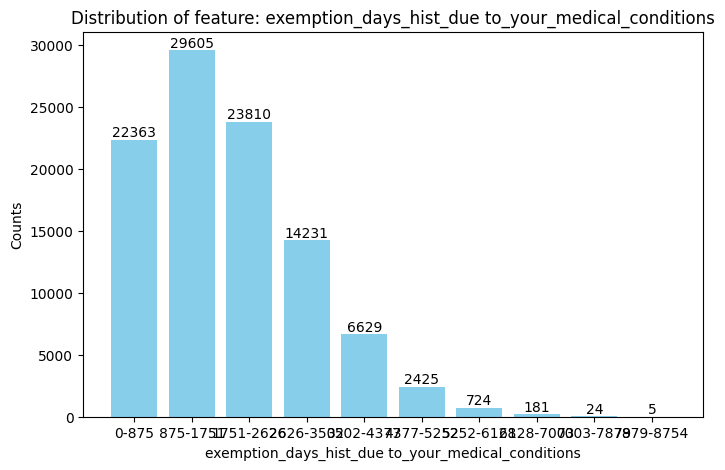

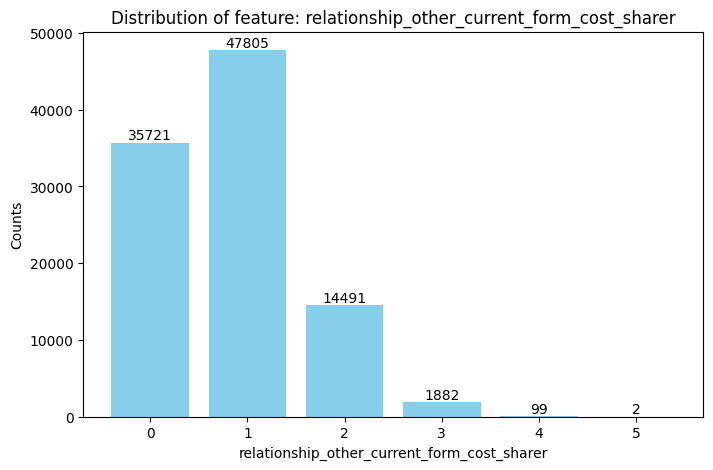

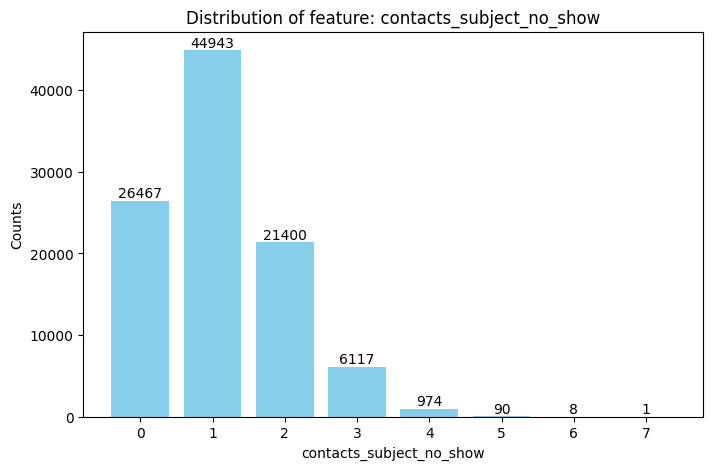

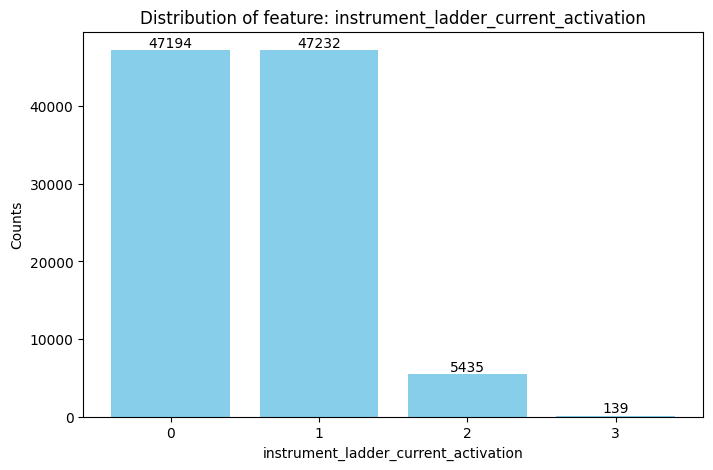

C:\Users\chena\PycharmProjects\TestingProject\src\utils\plot_utils.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = data.groupby('Bins')['Counts'].sum()


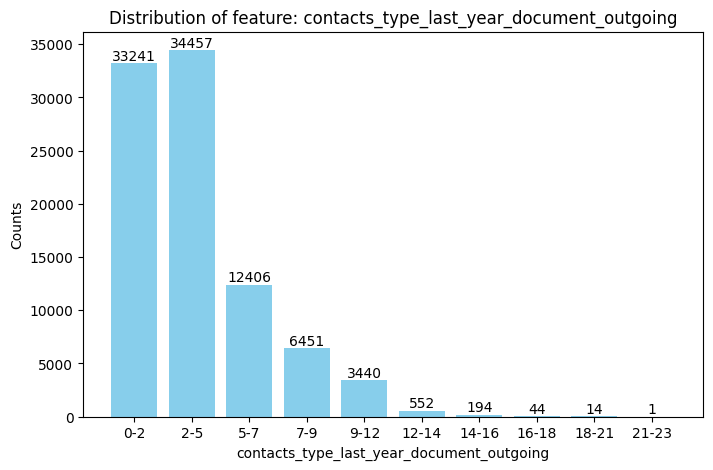

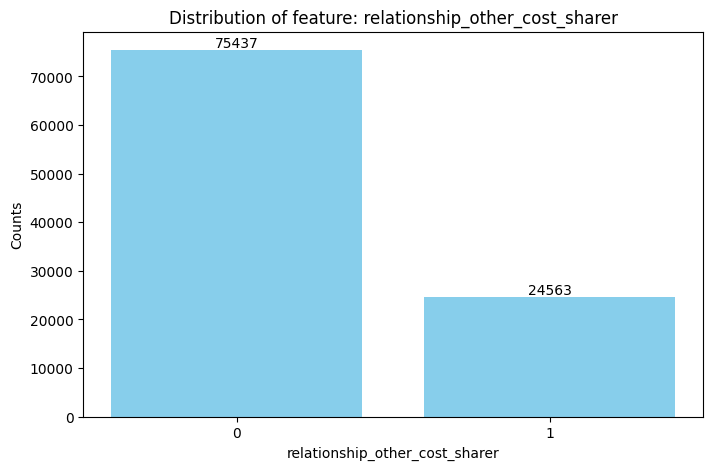

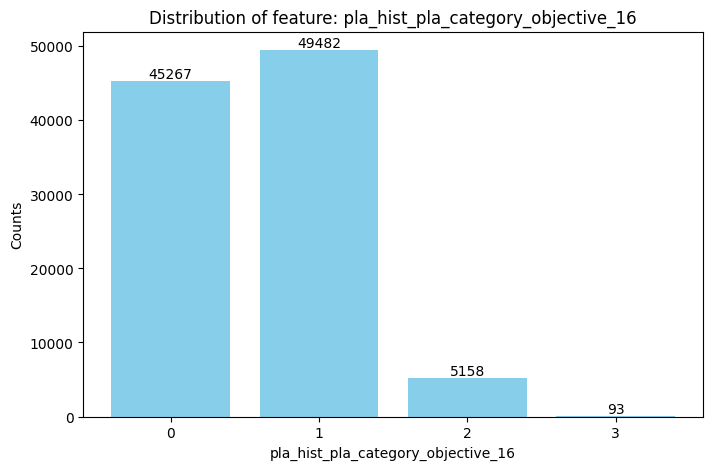

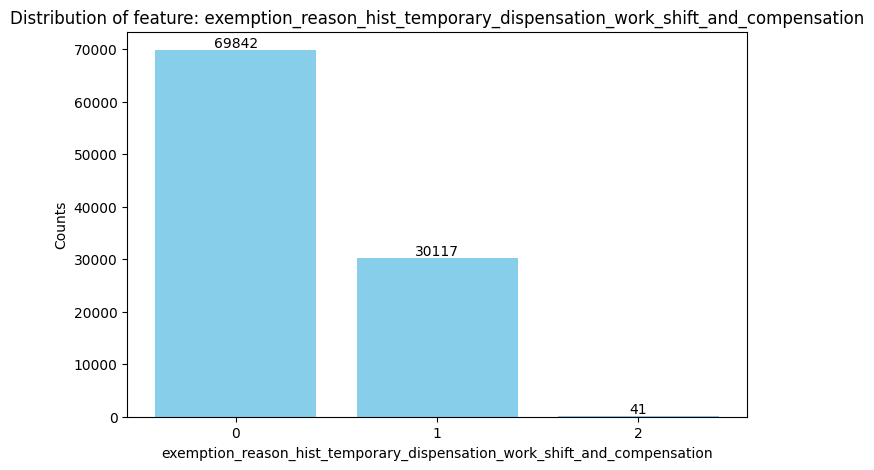

In [11]:
for feature in top_features_en.keys():
    plot_distribution(X_en[feature], feature)

### Train model on modified data

In [ ]:
model_path = target_model_dir + '/' + get_versioned_name(target_model_dir, 'gboost1_v', '.onnx', create_new=False) # set to true to create new version
run(X_prime, y_prime, model_path)

In [ ]:
# Let's load the model
new_session = rt.InferenceSession(model_path)

# Let's predict the target
y_pred_onnx =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)